In [1]:
%matplotlib inline
import numpy, xarray
from glob import glob
from sys import stdout
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import seaborn

In [2]:
# cases to plot
cases = ('FC5.ce12.ne30_ne30.test', 'FC5.ce12.ne30_ne30.nudgeUV',
         'FC5.sp20.ne30_ne30.test', 'FC5.sp20.ne30_ne30.nudgeUV',)
         #'FSPCAMm.sp20.ne30_ne30.test', 'FSPCAMm.sp20.ne30_ne30.nudgeUV')

# variables to look at
vnames = ('U200', 'V200', 'T200', 'U850', 'V850', 'T850', 'PSL')

# where is the data stored?
cases_root = '/Users/bhillma/gscratch/cesm/archive'
obs_root = '/Users/bhillma/gscratch/era-i/cam.se'

# on what history tapes should we look?
htape = 'h1'

In [3]:
# define some cesm utilities
# these should go into a separate package
import nclpy  # my port of NCL fortran routines to Python

def area_average(vdata, lat):
    weights = numpy.cos(numpy.pi * lat / 180.0) * vdata / vdata
    return (weights * vdata).sum() / weights.sum()


def area_rmse(vtest, vcntl, lat):
    weights = numpy.cos(numpy.pi * lat / 180.0) * vdata / vdata * vcntl / vcntl
    return numpy.sqrt((weights * (vtest - vcntl) ** 2).sum() / weights.sum())

    
def get_var_at_plev(ds, vname, plev):
    vname_plev = '%s%0f'%(vname, plev)
    if vname_plev in ds:
        return ds[vname_plev]
    else:
        # Interpolate to pressure level
        # TODO: implement this in python?
        # This also needs some smarter dimension checking
        vint = nclpy.vinth2p(
            ds[vname].transpose('time', 'ncol', 'lev'), ds.hyam, ds.hybm, 
            1e-2 * ds.P0, ds.PS, numpy.array([plev,]),
        )
        
        vint = xarray.DataArray(
            vint, dims=('time', 'ncol', 'plev'), coords={'time': ds.time},
            attrs={'long_name': '%.0f hPa %s'%(plev, ds[vname].long_name.lower()), 'units': ds[vname].units}
        )
        
        # add to dataset
        ds.update({vname_plev: vint})
        
        return vint
    
    
def get_var(ds, vname):
    if vname == 'U850':
        return get_var_at_plev(ds, 'U', 850)
    elif vname == 'U500':
        return get_var_at_plev(ds, 'U', 500)
    elif vname == 'U250':
        return get_var_at_plev(ds, 'U', 250)
    if vname == 'V850':
        return get_var_at_plev(ds, 'V', 850)
    elif vname == 'V500':
        return get_var_at_plev(ds, 'V', 500)
    elif vname == 'V250':
        return get_var_at_plev(ds, 'V', 250)
    elif vname == 'Z500':
        return get_var_at_plev(ds, 'Z3', 500)
    elif vname == 'T850':
        return get_var_at_plev(ds, 'T', 850)
    elif vname == 'T250':
        return get_var_at_plev(ds, 'T', 250)
    elif vname == 'NETCF':
        netcf = ds['SWCF'] + ds['LWCF']
        netcf.attrs = ds['SWCF'].attrs
        netcf.attrs.update({'long_name': 'Net cloud radiative effect'})
        return  netcf
    else:
        return ds[vname]
    

def get_datetimes(ds):
    import pandas
    dates = ds.date
    datesecs = ds.datesec
    hours = datesecs / 3600
    fulldates = ['%i%02i'%(d, h) for (d, h) in zip(dates, hours)]
    return pandas.to_datetime(fulldates, format='%Y%m%d%H')    

Code to compare multiple cases:

FC5.ce12.ne30_ne30.test
FC5.ce12.ne30_ne30.nudgeUV
FC5.sp20.ne30_ne30.test
FC5.sp20.ne30_ne30.nudgeUV


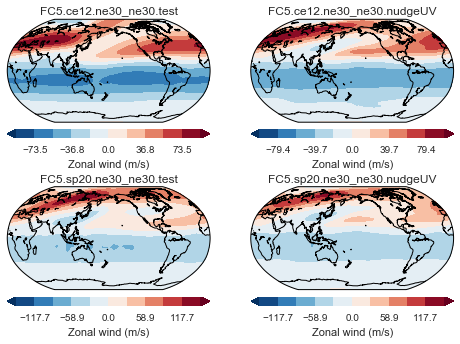

In [4]:
# code to plot full fields
# loop over variables; plot full fields
for ivar, vname in enumerate(('U',)):  
    figure, axes = pyplot.subplots(2, 2)
    plot_handles = []
    vmin = None
    vmax = None
    
    # loop over cases
    for icase, case in enumerate(cases):
        print(case); stdout.flush()

        # find files for this case
        files = sorted(glob('%s/%s/atm/hist/*.cam.%s.*'%(cases_root, case, htape)))
        if len(files) == 0:
            print('No files found for %s'%(case))
            continue

        # read data
        ds = xarray.open_mfdataset(files, concat_dim='time', decode_times=False)
        ds.coords['time'] = get_datetimes(ds)

        # get date range so we can calculate appropriate averages from obs files
        d1, d2 = ds.time[0], ds.time[-1]

        if vname not in ds.variables.keys():
            print('Variable %s not found.'%(vname)); stdout.flush()
            continue

        data = get_var(ds, vname)
        data = data.mean('time', keep_attrs=True).squeeze()
        if 'lev' in data.dims:
            data = data.isel(lev=0)

        # plot full fields
        ax = figure.add_axes(axes.ravel()[icase])

        # setup map
        m = Basemap(projection='robin', lon_0=180)
        x, y = m(ds.lon.values, ds.lat.values)
        m.drawcoastlines()

        # get mins and maxes
        if vmin is None:
            vmin = data.min().values
        else:
            vmin = min(vmin, data.min().values)
        
        if vmax is None:
            vmax = data.max().values
        else:
            vmax = max(vmax, data.max().values)
        
        # get levels and appropriate colormap
        if vmin < 0 and vmax > 0:
            levels = numpy.linspace(-max(abs(vmin), vmax), vmax, 11)
            cmap = pyplot.get_cmap('RdBu_r')
        else:
            levels = numpy.linspace(vmin, vmax)
            cmap = pyplot.get_cmap('plasma')
        
        
        # draw contour plot
        pl = m.contourf(x, y, data.squeeze(), 
                        tri=True, cmap=cmap,
                        levels=levels, extend='both')

        ax.set_title(case)

        cb = pyplot.colorbar(pl, ax=ax, orientation='horizontal',
                             label='%s (%s)'%(data.long_name, data.units),
                             pad=0.05)#fraction=0.05, pad=0.02)
        plot_handles.append(pl)
        ds.close()
        
    #for pl in plot_handles:
    #    pl.set_clim(vmin, vmax)
    
    #figure.subplots_adjust(hspace=0.02, wspace=0.02)
    #cb = pyplot.colorbar(pl, ax=axes.ravel().tolist(), orientation='horizontal',
    #                     label='%s (%s)'%(data.long_name, data.units), fraction=0.05, pad=0.02)
    

FC5.ce12.ne30_ne30.test
FC5.ce12.ne30_ne30.nudgeUV
FC5.sp20.ne30_ne30.test
FC5.sp20.ne30_ne30.nudgeUV


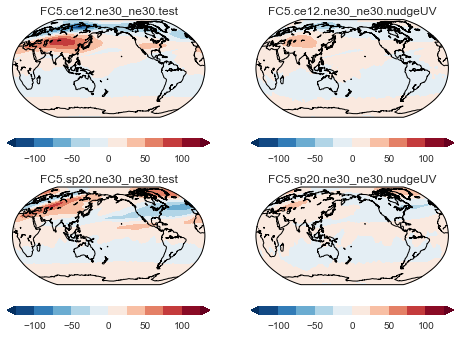

In [6]:
# loop over variables; plot full fields
for ivar, vname in enumerate(('U',)):  
    figure, axes = pyplot.subplots(2, 2)
    vmin = -125
    vmax = 125
    
    # first, find and open obs files (as dask arrays)
    # we do this inside the loop, because in general we might have different
    # obs cases for different variables; i.e., we want to compare with ERA-I
    # or NCEP reanalyses for things like winds, pressure, geopotential height, etc.,
    # but for clouds we will compare with CloudSat, CALIPSO, MISR, ISCCP, MODIS, etc.
    obs_files = sorted(glob('%s/*.nc'%(obs_root)))
    ds_obs = xarray.open_mfdataset(obs_files, concat_dim='time', decode_times=False)
    ds_obs.coords['time'] = get_datetimes(ds_obs)
    
    # now, loop over cases
    for icase, case in enumerate(cases):
        print(case); stdout.flush()

        # find files for this case
        files = sorted(glob('%s/%s/atm/hist/*.cam.%s.*'%(cases_root, case, htape)))
        if len(files) == 0:
            print('No files found for %s'%(case))
            continue

        # read data
        ds = xarray.open_mfdataset(files, concat_dim='time', decode_times=False)
        ds.coords['time'] = get_datetimes(ds)

        # get date range so we can calculate appropriate averages from obs files
        d1, d2 = ds.time[0], ds.time[-1]

        if vname not in ds.variables.keys():
            print('Variable %s not found.'%(vname)); stdout.flush()
            continue

        data = ds[vname].mean('time', keep_attrs=True).squeeze()
        if 'lev' in data.dims:
            data = data.isel(lev=0)

        # get obs means over appropriate time period
        if vname not in ds_obs.variables.keys():
            print('Variable %s not found in obs data.'%(vname)); stdout.flush()
            continue
        data_obs = ds_obs[vname].sel(time=slice(d1.astype(str), d2.astype(str))).mean('time', keep_attrs=True)
        if 'lev' in data_obs.dims:
            data_obs = data_obs.isel(lev=0)

        # calculate difference
        data_diff = data - data_obs

        # plot difference
        ax = figure.add_axes(axes.ravel()[icase])

        m = Basemap(projection='robin', lon_0=180)
        x, y = m(ds.lon.values, ds.lat.values)
        m.drawcoastlines()

        pl = m.contourf(x, y, data_diff.squeeze(),
                        tri=True, cmap=pyplot.get_cmap('RdBu_r'),
                        levels=numpy.linspace(vmin, vmax, 11),
                        extend='both')
        ax.set_title(case)
        cb = pyplot.colorbar(pl, ax=ax, orientation='horizontal')
                
        ds.close()

    ds_obs.close()